In [1]:
%matplotlib inline
import numpy as np
import scipy
import pandas
import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
pandas.set_option('display.max_columns', 20)
pandas.set_option('display.width', 350)

//miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data=pandas.read_csv('./dataset/subscription.csv')

In [3]:
data.head()

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,"January, 2015",29,Spain,ads,4,0
1,12474,"January, 2015",49,France,ads,5,0
2,12294,"January, 2015",49,Germany,ads,2,0
3,3878,"January, 2015",49,China,ads,1,0
4,9567,"January, 2015",49,UK,ads,5,0


# Q: A model that predicts monthly retention rate for the different subscription price points

Most of data science today focuses on building machine learning models, and specifically binary classification models. However, there are quite a few situations where, if you want to predict something, you need to fit a curve. Building a retention curve is one of the most common ones.

The standard approach to this is:

1) Try to see if the relationship is linear. If yes, build a linear regression and you are done.

2) If the relationship is not linear, try to see if some standard non-linear transformation of the variables can lead to a linear relationship

3) If 2 also fails, use more flexible models. Gam is probably the most common one. Actually, some suggest to just use gam no matter what since there are no significant downsides in using it and you are pretty much guaranteed to get same or better predictions compared to linear regressions. While this is true from a statistical standpoint, from a product DS standpoint there are significant advantages in using a linear regression when it comes to communicating your work to non-technical people.

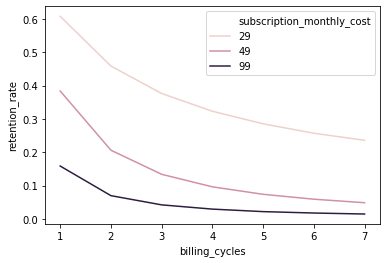

In [4]:
#firstly get count by billing cycle and price point
retention_rate_data_points = data.groupby(['subscription_monthly_cost', 'billing_cycles']).size().reset_index(name = 'tmp_count_billing')
  
#then estimate retention rate: cumulative sum by billing cycle divided by total users gives churn rate
#i.e. 1 - churn_rate is actual retention rate
retention_rate_data_points['retention_rate'] = retention_rate_data_points.groupby('subscription_monthly_cost')['tmp_count_billing'].transform(
                                               lambda x: 1-x.cumsum()/x.sum()
                                               )
  
# remove tmp_count_billing column and billing cycle == 8 because those are still active
retention_rate_data_points = retention_rate_data_points.drop('tmp_count_billing', 1).query('billing_cycles < 8')
  
#plot them
sns.lineplot(x="billing_cycles", y="retention_rate", 
             hue="subscription_monthly_cost", data=retention_rate_data_points, legend="full"
             )

In [5]:
retention_rate_data_points.query('subscription_monthly_cost==29')

,subscription_monthly_cost,billing_cycles,retention_rate
0,29,1,0.607542
1,29,2,0.458473
2,29,3,0.376232
3,29,4,0.323028
4,29,5,0.285416
5,29,6,0.257157
6,29,7,0.235901


For instance, for the cheapest price point, 40% of people churn after only 1 billing cycle, 15% after 2, 8% after 3, and so on. In a situation like that, a logarithm transformation can help make the relationship linear. Also, retention rate cannot be negative. Using log(billing_cycle) and log(retention_rate) in the regressions as variables should therefore help both ways: make the relationship more linear and make sure retention won’t be negative.

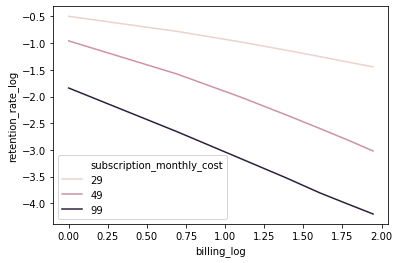

In [6]:
# create new feature using logs
retention_rate_data_points["billing_log"] = np.log(retention_rate_data_points["billing_cycles"])
 
retention_rate_data_points["retention_rate_log"] = np.log(retention_rate_data_points["retention_rate"])
 
#plot 
sns.lineplot(x="billing_log", y="retention_rate_log", 
             hue="subscription_monthly_cost", data=retention_rate_data_points, legend="full"
             )

In [7]:
import statsmodels.api as sm
  
#build linear model for price 29
y29 = retention_rate_data_points.query('subscription_monthly_cost==29')['retention_rate_log']
X29 = retention_rate_data_points.query('subscription_monthly_cost==29')['billing_log']
X29 = sm.add_constant(X29)
model29 = sm.OLS(y29, X29)
results29 = model29.fit()

In [10]:
print("R Squared for 29$ is:", round(results29.rsquared,2))
#build linear model for price 49
y49 = retention_rate_data_points.query('subscription_monthly_cost==49')['retention_rate_log']
X49 = retention_rate_data_points.query('subscription_monthly_cost==49')['billing_log']
X49 = sm.add_constant(X49)
  
model49 = sm.OLS(y49, X49)
results49 = model49.fit()
print("R Squared for 49$ is:", round(results49.rsquared,2))
#build linear model for price 99
y99 = retention_rate_data_points.query('subscription_monthly_cost==99')['retention_rate_log']
X99 = retention_rate_data_points.query('subscription_monthly_cost==99')['billing_log']
X99 = sm.add_constant(X99)
  
model99 = sm.OLS(y99, X99)
results99 = model99.fit()
print("R Squared for 99$ is:", round(results99.rsquared,2))

R Squared for 29$ is: 0.99
R Squared for 49$ is: 1.0
R Squared for 99$ is: 1.0


Looks like a good fit for all of them. If this hadn’t worked, we could have tried additional transformations or simply gam.

# Q: Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?

Now we can simply feed the regression with billing cycles up to 12 and get the output.

In [11]:
#make the predictions
Xpred = np.log(range(8,13))
Xpred = sm.add_constant(Xpred)
print(results29.predict(Xpred))
#However, our regression is actually predicting log(retention_rate). To get retention rate, we need to take the exponential of those predictions
print(np.exp(results29.predict(Xpred)))
print("For the 29$ price point, after 1 year, we will retain", 
      round(np.exp(results29.predict(Xpred))[4], 3), 
     "of our customers")
#Do the same for the other price points.
print("For the 49$ price point, after 1 year, we will retain", 
      round(np.exp(results49.predict(Xpred))[4], 3), 
     "of our customers")
print("For the 99$ price point, after 1 year, we will retain", 
      round(np.exp(results99.predict(Xpred))[4], 3), 
     "of our customers")

[-1.48549968 -1.54324007 -1.5948906  -1.64161419 -1.68426949]
[0.22638919 0.21368762 0.20293073 0.19366717 0.18557995]
For the 29$ price point, after 1 year, we will retain 0.186 of our customers
For the 49$ price point, after 1 year, we will retain 0.029 of our customers
For the 99$ price point, after 1 year, we will retain 0.008 of our customers


Let’s get for each price point the average customer one year value. This can be defined as customer LTV.


In [12]:
#our models work well enough that we can directly use their predictions for all 12 billing cycle to estimate customer LTV.
  
Xpred = np.log(range(1,13))
Xpred = sm.add_constant(Xpred)
#Firstly get retention rate for each billing cycle
retention_rate_tmp = np.exp(results29.predict(Xpred))
#Then get overall expected value by multiplying each probability * corresponding money at each billing cycle.
LTV_29 = 29 + sum(retention_rate_tmp * 29)
print("Avg LTV of customers paying 29$ a month is:", round(LTV_29), "dollars")
#do it for other price points
retention_rate_tmp = np.exp(results49.predict(Xpred))
LTV_49 = 49 + sum(retention_rate_tmp * 49)
print("Avg LTV of customers paying 49$ a month is:", round(LTV_49), "dollars")
retention_rate_tmp = np.exp(results99.predict(Xpred))
LTV_99 = 99 + sum(retention_rate_tmp * 99)
print("Avg LTV of customers paying 99$ a month is:", round(LTV_99), "dollars")

Avg LTV of customers paying 29$ a month is: 132.0 dollars
Avg LTV of customers paying 49$ a month is: 107.0 dollars
Avg LTV of customers paying 99$ a month is: 139.0 dollars


Therefore, the highest LTV is for users paying 99 dollars. However, considering that 29 has a much higher 1 year retention rate, if we had taken a larger time window to define LTV, 29 would have likely been the best one.

# Q: How do user country and source affect subscription retention rate? How would you use these findings to improve the company revenue?

As a first step, let’s see the proportion of users that are still active after 8 months for the different price points by country and source to see if there are any major differences.

Let’s check by country first:

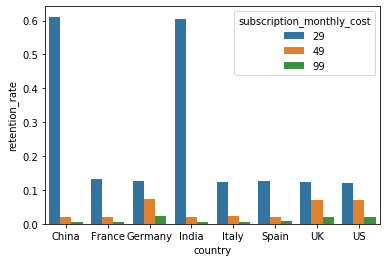

In [13]:
#group by country and price and check retention rate as defined above
country_retention = data.groupby(['country', 'subscription_monthly_cost']).apply(
                    lambda x: pandas.Series({
                             # active users
                            'retention_rate': x['is_active'].mean(),
                             # total count by price and country
                            'count': x['is_active'].count(),
                            # avg revenue by price and country
                            'revenue' : (x['subscription_monthly_cost'] * x['billing_cycles']).mean()
  })
).reset_index()
      
#Let's plot retention rate by country and price
sns.barplot(x="country", hue="subscription_monthly_cost", y="retention_rate", data=country_retention)

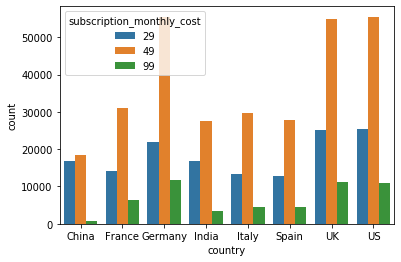

In [14]:
#Let's plot user count by country and price
sns.barplot(x="country", hue="subscription_monthly_cost", y="count", data=country_retention)

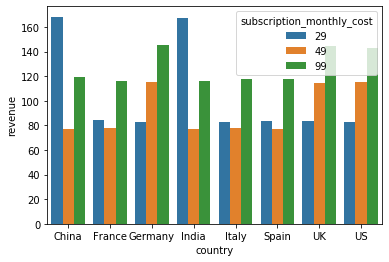

In [16]:
#Let's find out for each country avg user revenue within the first 8 months
sns.barplot(x="country", hue="subscription_monthly_cost", y="revenue", data=country_retention)

# Findings:

China and India have huge retention rate for the cheapest price point. Maybe too good to be true? A deep dive would be useful to understand why. They are also much more likely to choose the 29$ option compared to the other countries


India and China best price point is the cheapest one. For all other countries, the best price point is the most expensive one. However, unfortunately, all countries have the highest proportion of subscribers for the middle price! Exactly the opposite of what we would like to have!!
If we could shift users towards the optimal price point, this would increase user LTV, and that would have several positive effects, beside the obvious revenue gain. For instance, higher LTV means that we could bid higher for ads, and therefore grow much faster


The goal is essentially to make given price points more attractive on a country basis. A way to achieve this would be to change the UI so that, for each country, the optimal price point is more prominent.
Another approach could be to look into how users from each country are using the product. Figure out what they like the most and then play around with each price point features in such a way that the best price has the most attractive features for each country.
Another approach could be targeted/regional coupons


The good news is that, although retention is a long term metric, it is actually very easy to predict long term retention just by looking at the first month or so. That makes so much easier to run A/B tests and iterate fast.



Let’s now do the same for source:

In [17]:
#group by source and price and check retention rate as defined above
source_retention = data.groupby(['source', 'subscription_monthly_cost']).apply(
                    lambda x: pandas.Series({
                             # active users
                            'retention_rate': x['is_active'].mean(),
                             # total count by price and source
                            'count': x['is_active'].count(),
                            # avg revenue by price and source
                            'revenue' : (x['subscription_monthly_cost'] * x['billing_cycles']).mean()
  })
).reset_index()
      
#Let's plot retention rate by source and price

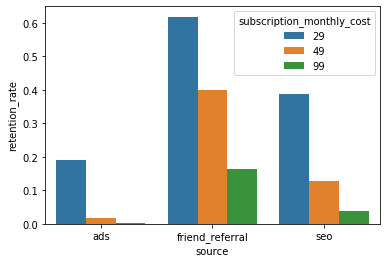

In [18]:
sns.barplot(x="source", hue="subscription_monthly_cost", y="retention_rate", data=source_retention)

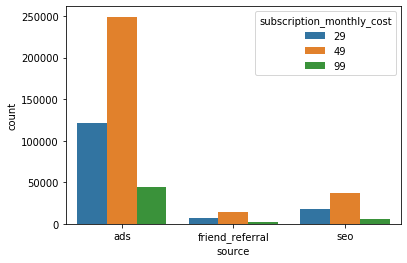

In [19]:
#Let's plot user count by source and price
sns.barplot(x="source", hue="subscription_monthly_cost", y="count", data=source_retention)

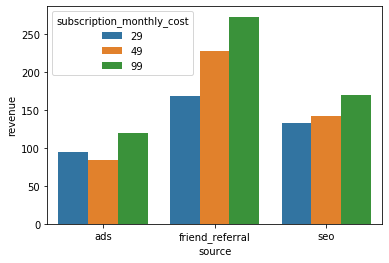

In [20]:
#Let's find out for each source avg user revenue within the first 8 months
sns.barplot(x="source", hue="subscription_monthly_cost", y="revenue", data=source_retention)

# Findings:

The high majority of users is coming from ads. Unfortunately, these users have the lowest retention and, consequently, the lowest LTV. Even worse, those ads are mainly attracting 49$ customers. That’s highly inefficient. Ads campaigns should be optimized to attract customers with higher likelihood of buying the optimal price point


Friend referral is doing really well, but has very low absolute numbers. Increasing this is a big opportunity. And btw the discount that is usually given to referred users can also be used as a leverage for the price discussion from above


SEO is also doing better than ads in terms of retention, but there are way less users. This is also a big opportunity, especially because SEO is the only one that doesn’t cost anything.


Overall these findings can be super useful especially for marketing. We found several segments that are doing well, but are under represented as a proportion of total users. And these are by far the best/most actionable insights to give the marketing team.